In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import sympy as sp
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline

# 6.3

In [2]:
class ExpDistribution():
    def __init__(self, alpha = 3, beta = 3) -> None:
        self.alpha = alpha
        self.beta = beta

        self.x = sp.Symbol("x")
        self.expr = sp.exp(-sp.Abs(self.x)**self.alpha/self.beta)
        self.k = np.float64(1/sp.integrate(self.expr, (self.x, -sp.oo, sp.oo)))
        self.var = sp.integrate(self.x**2*self.k*self.expr, (self.x, -sp.oo, sp.oo))

    def prob(self, x):
        return self.k*np.exp(-np.abs(x)**self.alpha/self.beta)
    
    def normal(self, x, mu = 0, cov = 1):
        return 1/np.sqrt(2*np.pi*cov)*np.exp(-1/2*(x-mu)**2/cov)
    
    def ImportanceSampling_stdnorm(self, sample_size = 10000, seed = 1024):
        np.random.seed(seed)
        from numpy.random import default_rng
        rng = default_rng(seed = seed)
        samples = rng.normal(0, 1, size=sample_size)
        weight = self.prob(samples)/self.normal(samples)
        weight = weight/np.sum(weight)
        var = np.sum(weight*samples**2)

        return var
    
    def RejectionSampling_stdnorm(self, sample_size = 10000, seed = 1024):
        np.random.seed(seed)
        X = np.arange(-10, 10, 1e-2)
        Y_prob = self.prob(X)
        Y_norm = self.normal(X)
        scale = 1
        while(np.any((Y_prob - scale*Y_norm)>0)):
            scale += 0.01
        from numpy.random import default_rng
        rng = default_rng(seed = seed)
        count = 0
        samples = []
        while(count<sample_size):
            tmp_samples = rng.normal(0, 1, size=sample_size-count)
            prob = self.prob(tmp_samples)
            norm = scale*self.normal(tmp_samples)
            values = rng.uniform(0, 1, sample_size-count)
            values = values*norm
            idx = np.where(values <= prob)
            samples.append(tmp_samples[idx])
            count += tmp_samples[idx].shape[0]
        samples = np.concatenate(samples)
        var = np.mean(samples**2)

        return var
    
    def PhilippeRobertMethod_stdnorm(self, sample_size = 10000, seed = 1024):
        np.random.seed(seed)
        from numpy.random import default_rng
        rng = default_rng(seed = seed)
        samples = rng.normal(0, 1, size=sample_size)
        sorted_samples = np.sort(samples)

        delta_xs = sorted_samples[1:] - sorted_samples[:-1]
        q_xs = self.prob(sorted_samples[:-1])
        hs = sorted_samples[:-1]**2
        factor1 = np.sum(delta_xs*hs*q_xs)
        factor2 = np.sum(delta_xs*q_xs)

        return factor1/factor2
    
    def CompareMethods(self, sample_size = 10000):
        names = ["Importance Sampling", "Rejection Sampling", "Philippe Robert Sampling"]
        results = [[] for name in names]
        for seed in range(1024):
            results[0].append(self.ImportanceSampling_stdnorm(sample_size, seed))
            results[1].append(self.RejectionSampling_stdnorm(sample_size, seed))
            results[2].append(self.PhilippeRobertMethod_stdnorm(sample_size, seed))
        results = np.array(results)

        fig = plt.figure(figsize = (10, 5))
        plt.boxplot(results.T)
        plt.xticks(range(1, len(names) + 1), names)
        plt.grid(True)
        fig.show()

In [3]:
ed = ExpDistribution(alpha = 3, beta = 3)

In [4]:
ed.ImportanceSampling_stdnorm(sample_size = 10000)

0.7751669496314346

In [5]:
ed.RejectionSampling_stdnorm(sample_size = 10000)

0.7720989696323239

In [6]:
ed.PhilippeRobertMethod_stdnorm(sample_size = 10000)

0.776472331075688

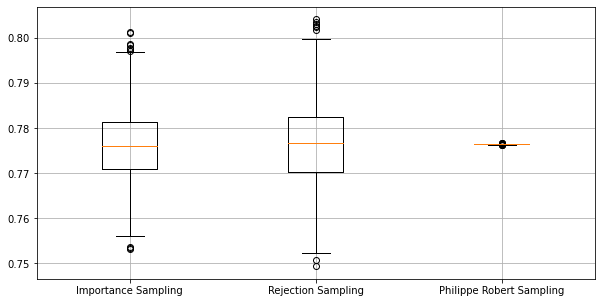

In [7]:
ed.CompareMethods(sample_size = 10000)

# 6.6

In [8]:
class Poisson():
    def __init__(self, num_data = 25, lamda = 2, alpha = 0.05, Z_rej = 1.645, lamda_q = 2.4653) -> None:
        from scipy.special import gamma
        from scipy.stats import poisson
        self.num_data = num_data
        self.lamda = lamda
        self.alpha = alpha
        self.Z_rej = Z_rej
        self.lamda_q = lamda_q

        self.F_gamma = gamma
        self.poisson_pdf = poisson.pmf

    def prob(self, data, lamda):
        return np.exp(-lamda)*(lamda**data)/self.F_gamma(lamda + 1)

    def Z_value(self, mean, lamda = 2, num_data = 25):
        return (mean-lamda)/np.sqrt(lamda/num_data)
    
    def uniform_2_poisson(self, u, lamda):
        x = np.zeros(u.shape)
        P = np.exp(-lamda)*np.ones(x.shape)
        S = P

        idx = np.where(u > S)
        x[idx] += 1
        P = lamda*P/self.F_gamma(x+1)
        S = S + P
        while(np.any(u > S)):
            idx = np.where(u > S)
            x[idx] += 1
            P[idx] = P[idx]*lamda/(x[idx])
            S[idx] = S[idx] + P[idx]
            
        return x
    
    def StandardSampling(self, lamda, num_iterations = 1000, seed = 1024):
        np.random.seed(seed)
        from numpy.random import default_rng
        rng = default_rng(seed = seed)

        sample = rng.poisson(lamda, size = (num_iterations, self.num_data))
        mean = np.mean(sample, axis=1)
        z = self.Z_value(mean)
        count = np.where(z >= self.Z_rej)[0].shape[0]

        return count/num_iterations
    
    def AntitheticSampling(self, lamda, num_iterations = 1000, seed = 1024):
        np.random.seed(seed)
        from numpy.random import default_rng
        rng = default_rng(seed = seed)

        uniform_sample = rng.uniform(0, 1, size = (num_iterations, self.num_data))
        sample1 = self.uniform_2_poisson(uniform_sample, lamda)
        sample2 = self.uniform_2_poisson(1 - uniform_sample, lamda)
        mean1 = np.mean(sample1, axis=1)
        mean2 = np.mean(sample2, axis=1)
        z1 = self.Z_value(mean1)
        z2 = self.Z_value(mean2)
        count1 = np.where(z1 >= self.Z_rej)[0].shape[0]
        count2 = np.where(z2 >= self.Z_rej)[0].shape[0]

        value = (count1 + count2)/(2*num_iterations)

        return value
    
    def ImportanceSampling(self, lamda, num_iterations = 1000, seed = 1024, standard_weight = False):
        np.random.seed(seed)
        from numpy.random import default_rng
        rng = default_rng(seed = seed)

        flag = np.zeros(num_iterations)
        sample = rng.poisson(self.lamda_q, size = (num_iterations, self.num_data))
        weight = self.prob(sample, lamda)/self.prob(sample, self.lamda_q)
        if(standard_weight):
            weight = weight/np.sum(weight, axis=1, keepdims=True)
            mean = np.sum(sample*weight, axis=1)
            z = self.Z_value(mean)
            idx = np.where(z >= self.Z_rej)
            flag[idx] = 1
            count = np.sum(flag[idx])
        else:
            mean = np.mean(sample*weight, axis=1)/np.mean(weight, axis = 1)
            z = self.Z_value(mean)
            idx = np.where(z >= self.Z_rej)
            flag[idx] = 1
            count = np.sum(flag[idx])

        return count/num_iterations
    
    def compare(self, lamda, num_iterations = 100):
        names = ["Standard Sampling", "Antithetic Sampling", "Importance Sampling", "Importance Sampling (Standard Weight)"]
        grade = ["Lb", "Mean", "Ub", "Sd"]
        result = [[] for name in names]
        for seed in range(num_iterations):
            result[0].append(self.StandardSampling(lamda,1000, seed))
            result[1].append(self.AntitheticSampling(lamda, 1000, seed))
            result[2].append(self.ImportanceSampling(lamda, 1000, seed))
            result[3].append(self.ImportanceSampling(lamda, 1000, seed, standard_weight = True))
        #result[4] = result[2] + 
        ret = [[]for name in names]
        for i, item in enumerate(result):
            ret[i].append(np.quantile(item, 0.025))
            ret[i].append(np.mean(item))
            ret[i].append(np.quantile(item, 0.975))
            ret[i].append(np.std(item))
        ret = pd.DataFrame(ret)
        ret.columns = grade
        ret.index = names
        return ret
    
    def plotResults(self, down_lamda=2.2, up_lamda=4):
        tables = None
        names = ["Standard Sampling", "Antithetic Sampling", "Importance Sampling", "Importance Sampling (Standard Weight)"]
        colors = ["red", "green", "blue", "orange", "black"]
        tmp_lamdas = np.linspace(down_lamda, up_lamda, 20)
        for lamda in tmp_lamdas:
            tmp = self.compare(lamda)
            if(tables is None):
                tables = np.array(tmp.iloc[:, 2]).reshape(-1,1)
            else:
                tables = np.concatenate([tables, np.array(tmp.iloc[:, 2]).reshape(-1,1)], axis=1)
        
        plt.figure(figsize=(10,5))
        for i, name in enumerate(names):
            plt.plot(tmp_lamdas, tables[i], "-o", alpha = 0.5, color = colors[i], label=names[i])
        plt.legend()
        plt.xlabel("lamda")
        plt.ylabel("power")
        plt.show()


In [9]:
poisson = Poisson(num_data = 25, lamda = 2, alpha = 0.05, Z_rej = 1.645, lamda_q = 2.4653)

In [10]:
poisson.compare(lamda=2)

,Lb,Mean,Ub,Sd
Standard Sampling,0.039950,0.05678,0.075525,0.009290
Antithetic Sampling,0.046738,0.05673,0.066000,0.005177
Importance Sampling,0.045000,0.05990,0.074525,0.008674
Importance Sampling (Standard Weight),0.045000,0.05990,0.074525,0.008674


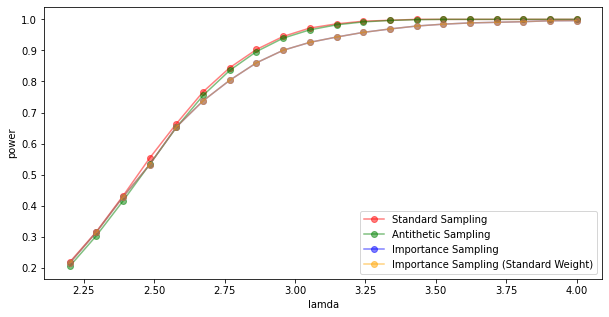

In [11]:
poisson.plotResults(2.2, 4)

# 6.7

In [32]:
class Stock():
    def __init__(self, S0 = 50, K = 52, sigma = 0.5, N = 30, r = 0.05) -> None:
        from scipy.stats import norm
        self.S0 = S0
        self.K = K
        self.sigma = sigma
        self.N = N
        self.r = r

        self.norm_cdf = norm.cdf
        self.norm_inv = norm.ppf
        self.StockValueStyle = {"Europ": self.StockValue_europ, "Asia": self.StockValue_asia}

    def BoxMuller(self, U):
        np.cos(2*np.pi*U)

    def StockValue_europ(self, t, S0 = 50, sigma = 0.5, r = 0.05, sample_size = np.int64(1e8), seed = 1024, variate_control = False, sample_method = "Simple"):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)
        G = None
        if(sample_method == "Antithetic"):
            U = rng.uniform(0, 1, size = sample_size)
            Z1, Z2 = self.norm_inv(U), self.norm_inv(1-U)
            S1 = S0*np.exp((r - 1/2*sigma**2)*t/365 + sigma*Z1*np.sqrt(t/365))
            S2 = S0*np.exp((r - 1/2*sigma**2)*t/365 + sigma*Z2*np.sqrt(t/365))
            S = (S1, S2)
        else:
            Z = rng.normal(0, 1, size = sample_size)
            S = S0*np.exp((r - 1/2*sigma**2)*t/365 + sigma*Z*np.sqrt(t/365))
        
        return S, G
    
    def StockValue_asia(self, T, S0 = 50, sigma = 0.5, r = 0.05, sample_size = np.int64(1e6), seed = 1024, variate_control = False, sample_method = "Simple"):
        from numpy.random import default_rng
        np.random.seed(seed)
        rng = default_rng(seed = seed)
        G = None
        if(sample_method == "Antithetic"):
            S1 = np.zeros((T + 1, sample_size)) + S0
            S2 = np.zeros((T + 1, sample_size)) + S0
            for t in range(1, T + 1, 1):
                Ut = rng.uniform(0, 1, size = sample_size)
                Zt1 = self.norm_inv(Ut)
                Zt2 = self.norm_inv(1-Ut)
                tmp1 = np.exp((r - 1/2*sigma**2)/365 + sigma*Zt1/np.sqrt(365))
                tmp2 = np.exp((r - 1/2*sigma**2)/365 + sigma*Zt2/np.sqrt(365))
                S1[t] = S1[t-1]*tmp1
                S2[t] = S2[t-1]*tmp2
            S_mean = (np.mean(S1[1:], axis=0), np.mean(S2[1:], axis=0))
            if(variate_control):
                G1, G2 = np.prod(S1[1:], axis=0), np.prod(S2[1:], axis=0)
                G = (G1, G2)
        else:
            S = np.zeros((T + 1, sample_size)) + S0
            for t in range(1, T + 1, 1):
                Zt = rng.normal(0, 1, size = sample_size)
                S[t] = S[t-1]*np.exp((r - 1/2*sigma**2)/365 + sigma*Zt/np.sqrt(365))
            S_mean = np.mean(S[1:], axis=0)
            if(variate_control):
                G = np.prod(S[1:], axis=0)
        
        return S_mean, G
    
    def Theta(self, T, N, S0 = 50, K = 52, sigma = 0.5, r = 0.05):
        c3 = 1 + 1/N
        c2 = sigma*np.sqrt(c3*T/(365*3)*(1+1/(2*N)))
        c1 = 1/c2*(np.log(S0/K) + c3*T/(365*2)*(r-1/2*sigma**2) + T*c3*sigma**2/(3*365)*(1+1/(2*N)))
        theta = S0*self.norm_cdf(c1)*np.exp(-T*((1-1/N)/(2*365))*(r + c3*sigma**2/6)) - K*self.norm_cdf(c1-c2)*np.exp(-r*T/365)

        return theta
    
    def FairPrice(self, t, S0 = 50, K = 52, sigma = 0.5, r = 0.05, option_style = "Europ", variate_control = False, sample_method = "Simple", seed = 1024):
        S, G = self.StockValueStyle[option_style](t, S0, sigma, r, variate_control = variate_control, sample_method = sample_method, seed = seed)
        if(sample_method == "Antithetic"):
            S1, S2 = S
            part1 = np.exp(-r*t/365)
            part21 = (S1 - K)*((S1 > K).astype(np.float64))
            part22 = (S2 - K)*((S2 > K).astype(np.float64))
            A1, A2 = part1*part21, part1*part22
            ret = 1/2*np.mean(A1) + 1/2*np.mean(A2)
        else:
            part1 = np.exp(-r*t/365)
            part2 = (S - K)*((S > K).astype(np.float64))
            A = part1*part2
            ret = np.mean(A)
        if(variate_control):
            theta = self.Theta(T=t, N=t, S0 = 50, K = 52, sigma = 0.5, r = 0.05)
            if(sample_method == "Antithetic"):
                G1, G2 = G
                part31 = (G1 - K)*((G1 > K).astype(np.float64))
                part32 = (G2 - K)*((G2 > K).astype(np.float64))
                Theta1, Theta2 = part1*part31, part1*part32
                meanA1, meanA2, meanTheta1, meanTheta2 = np.mean(A1), np.mean(A2), np.mean(Theta1), np.mean(Theta2)
                lamda1 = -np.mean(np.cov(A1, Theta1))/np.var(Theta1)
                lamda2 = -np.mean(np.cov(A2, Theta2))/np.var(Theta2)
                ret = 1/2*(meanA1 + lamda1*(meanTheta1 - theta)) + 1/2*(meanA2 + lamda2*(meanTheta2 - theta))
            else:
                G = G**(1/t)
                part3 = (G - K)*((G > K).astype(np.float64))
                Theta = part1*part3
                meanA, meanTheta= np.mean(A), np.mean(Theta)
                lamda = -np.mean(np.cov(A, Theta))/np.var(Theta)
                ret = meanA + lamda*(meanTheta - theta)

        return ret
    
    def Compare(self, t = 30, S0 = 50, K = 52, sigma = 0.5, r = 0.05, option_style = "Asia", num_iterations = 100):
        names = ["Simple Monte Carol", "Variate Control Monte Carol", "Antithetic Monte Carol"]
        variates = [False, True, False]
        sample_methods = ["Simple", "Simple", "Antithetic"]
        results = [[] for name in names]
        for seed in range(num_iterations):
            for i in range(len(names)):
                tmp = self.FairPrice(t, S0, K, sigma, r, option_style, variates[i], sample_methods[i], seed)
                results[i].append(tmp)
        results = np.array(results)

        return results
    
    def PlotCompareResults(self, results):
        names = ["Simple Monte Carol", "Variate Control Monte Carol", "Antithetic Monte Carol"]
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        plt.title("Comparison of the Three Sampling Methods Above.")
        axes[0].hist(results[0])
        axes[0].set_title(names[0])
        axes[1].hist(results[1])
        axes[1].set_title(names[1])
        axes[2].hist(results[2])
        axes[2].set_title(names[2])
        fig.show()

        fig = plt.figure(figsize=(10, 5))
        plt.boxplot(results.T)
        plt.xticks(range(1, len(names) + 1), names)
        plt.grid(True)
        fig.show()

In [33]:
stock = Stock(S0 = 50, K = 52, sigma = 0.5, N = 30, r = 0.05)

In [14]:
fair_price = stock.FairPrice(30, option_style = "Europ")
print("The expectation of european fair price is %f"%(fair_price))

The expectation of european fair price is 2.101421


In [15]:
fair_price = stock.FairPrice(30, option_style = "Asia")
print("The expectation of asian fair price is %f"%(fair_price))

The expectation of asian fair price is 0.944598


In [16]:
fair_price = stock.FairPrice(30, option_style = "Asia", variate_control = True)
print("The expectation of asian fair price is %f"%(fair_price))

The expectation of asian fair price is 0.944633


In [17]:
fair_price = stock.FairPrice(30, option_style = "Asia", variate_control = False, sample_method = "Antithetic")
print("The expectation of asian fair price is %f"%(fair_price))

The expectation of asian fair price is 0.941762


In [18]:
cmp_results = stock.Compare()

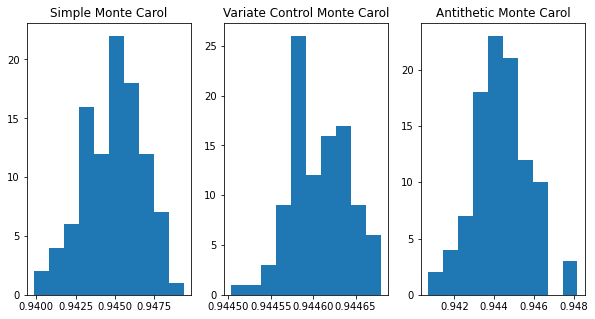

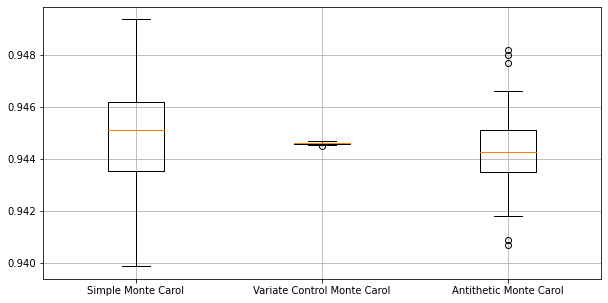

In [34]:
stock.PlotCompareResults(cmp_results)